In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

from torchvision import datasets, transforms
from torch.utils.data import DataLoader,WeightedRandomSampler,SubsetRandomSampler, Subset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import vit_b_16, ViT_B_16_Weights
from torchvision.transforms import AutoAugment, AutoAugmentPolicy
import math

In [2]:
train_transforms = transforms.Compose([
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5, fill=128),
    transforms.RandomRotation(15), 
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), ratio=(0.75, 1.33)), 
    transforms.RandomHorizontalFlip(0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [3]:
trainDataset = datasets.ImageFolder(root='/kaggle/input/nn-26-scene-style-classification/StyleClassificationIndoors/StyleClassificationIndoors/train', transform=train_transforms)
valDataset   = datasets.ImageFolder(root='/kaggle/input/nn-26-scene-style-classification/StyleClassificationIndoors/StyleClassificationIndoors/train', transform=val_transforms)

targets = trainDataset.targets
#split by index, not the actual data
train_idx, val_idx = train_test_split(
    np.arange(len(targets)), 
    test_size=0.2,           #80/20 split
    shuffle=True, 
    stratify=targets     #to keep the same distribution of classes in both sets
)

train_subset = Subset(trainDataset, train_idx)
val_subset   = Subset(valDataset, val_idx)

In [4]:
counter = Counter(trainDataset.targets)
for class_index, count in counter.most_common():
    class_name = trainDataset.classes[class_index]
    print(f"{class_name}: {count}")

boho: 918
eclectic: 809
modern: 809
farmhouse: 795
coastal: 794
mediterranean: 789
french-country: 788
contemporary: 782
asian: 779
southwestern: 772
tropical: 772
scandinavian: 768
craftsman: 764
industrial: 764
victorian: 759
shabby-chic-style: 746
minimalist: 555


In [5]:
train_targets = np.array(targets)[train_idx] #get all the training targets

#calculate the weights
class_counts = np.bincount(train_targets)
class_weights = 1. / class_counts

#map each label to its weight
sample_weights = class_weights[train_targets] #this create an array of len(train_targets), and its like every we are indexing by the target label 
sample_weights = torch.from_numpy(sample_weights).double()

train_sampler = torch.utils.data.WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

In [6]:
train_loader = DataLoader(
    train_subset, 
    batch_size=32, 
    sampler=train_sampler,
    num_workers=4
)

val_loader = DataLoader(
    val_subset, 
    batch_size=32, 
    shuffle=False,        
    num_workers=4
)

In [7]:
print(f"Training on {len(train_subset)} images.")
print(f"Validating on {len(val_subset)} images.")

Training on 10530 images.
Validating on 2633 images.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

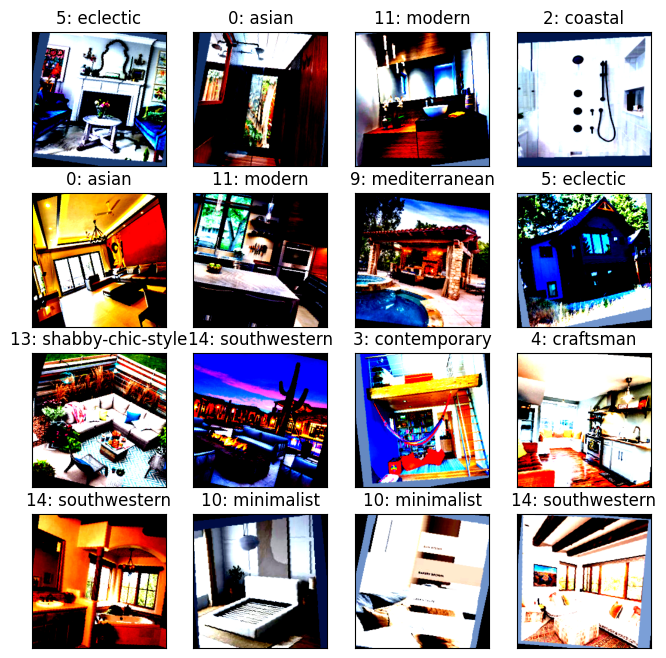

In [8]:
indoorStyleClasses = trainDataset.classes

data_iter = iter(train_loader)
images, labels = next(data_iter)

fig = plt.figure(figsize=(8, 8))

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    
    img_display = images[i].numpy().transpose((1, 2, 0))
    plt.imshow(img_display)
    idx = labels[i].item()
    real_name = indoorStyleClasses[idx]
    
    ax.set_title(f"{idx}: {real_name}")

plt.show()

In [9]:
def init_weights(module):
    if isinstance(module, nn.Linear):
        nn.init.xavier_uniform_(module.weight)
        if module.bias is not None:
            nn.init.constant_(module.bias, 0)
    elif isinstance(module, nn.Conv2d):
        nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
        if module.bias is not None:
            nn.init.constant_(module.bias, 0)
    elif isinstance(module, nn.LayerNorm):
        # LayerNorm default is fine
        pass

In [10]:
class PatchEmbed(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_ch=3, embed_dim=768):
        super().__init__()
        self.n_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_ch, embed_dim, kernel_size=patch_size, stride=patch_size)
    def forward(self, x):
        B, C, H, W = x.shape
        x = self.proj(x)
        x = x.flatten(2).transpose(1, 2)
        return x

    


In [11]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, attn_dropout=0.0, proj_dropout=0.0):
        super().__init__()

        assert embed_dim % num_heads == 0, "embed_dim must be divisible by num_heads"

        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5

        self.qkv = nn.Linear(embed_dim, embed_dim * 3, bias=True)
        self.attn_drop = nn.Dropout(attn_dropout)

        self.proj = nn.Linear(embed_dim, embed_dim)
        self.proj_drop = nn.Dropout(proj_dropout)

    def forward(self, x):
        # x: (B, N, C)
        B, N, C = x.shape

        # (B, N, 3C) > (3, B, heads, N, head_dim)
        qkv = (
            self.qkv(x)
            .reshape(B, N, 3, self.num_heads, self.head_dim)
            .permute(2, 0, 3, 1, 4)
        )
        q, k, v = qkv[0], qkv[1], qkv[2]

        # Scaled Dot product attention
        attn = (q @ k.transpose(-2, -1)) * self.scale   # (B, heads, N, N)
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        # Apply attention to values
        out = attn @ v                                 # (B, heads, N, head_dim)
        out = out.transpose(1, 2).reshape(B, N, C)     # (B, N, C)

        # Final projection
        out = self.proj(out)
        out = self.proj_drop(out)

        return out


In [12]:
class FeedForward(nn.Module):
    def __init__(self, embed_dim, hidden_dim, dropout=0.0):
        super().__init__()
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_dim, embed_dim)
        self.drop = nn.Dropout(dropout)
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


In [13]:
class EncoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_ratio=4.0, drop_rate=0.0, attn_drop=0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadSelfAttention(embed_dim, num_heads, attn_dropout=attn_drop, proj_dropout=drop_rate)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = FeedForward(embed_dim, int(embed_dim*mlp_ratio), dropout=drop_rate)
    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

In [14]:
class ViTFromScratch(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_ch=3, num_classes=17, embed_dim=256, depth=6, num_heads=8, mlp_ratio=4.0, drop_rate=0.1, attn_drop=0.0):
        super().__init__()
        self.patch_embed = PatchEmbed(img_size, patch_size, in_ch, embed_dim)
        n_patches = self.patch_embed.n_patches
        self.cls_token = nn.Parameter(torch.zeros(1,1,embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1,1+n_patches,embed_dim))
        self.pos_drop = nn.Dropout(drop_rate)
        self.blocks = nn.ModuleList([EncoderBlock(embed_dim, num_heads, mlp_ratio, drop_rate, attn_drop) for _ in range(depth)])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)
        nn.init.normal_(self.pos_embed,std=0.02)
        nn.init.normal_(self.cls_token,std=0.02)

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)
        cls_tokens = self.cls_token.expand(B,-1,-1)
        x = torch.cat((cls_tokens,x),dim=1) + self.pos_embed
        x = self.pos_drop(x)
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)
        out = self.head(x[:,0])
        return out

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Working on device: {device}")



Working on device: cuda


In [16]:
model = ViTFromScratch(img_size=224, patch_size=16, num_classes=17, embed_dim=256, depth=6, num_heads=8).to(device)


In [17]:
pretrained = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
pretrained_dict = pretrained.state_dict()
model_dict = model.state_dict()
# map weights that match by shape
for k,v in pretrained_dict.items():
    if k in model_dict and v.shape==model_dict[k].shape:
        model_dict[k] = v
model.load_state_dict(model_dict)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 223MB/s]


<All keys matched successfully>

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
num_epochs = 30

In [19]:

patience = 7            
counter = 0             
min_val_loss = float('inf') 

best_val_acc = 0.0

for epoch in range(num_epochs):
    # === Training Phase ===
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        
    train_acc = 100 * correct / total
    train_loss = running_loss / len(train_loader)

    # === Validation Phase ===
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)
            
    val_acc = 100 * val_correct / val_total
    val_loss = val_loss / len(val_loader)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_vit_from_scratch.pth')
        print(f"--> New Best Model Saved! Acc: {best_val_acc:.2f}%")

    scheduler.step(val_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")

    if val_loss < min_val_loss:
        min_val_loss = val_loss
        counter = 0  
    else:
        counter += 1
        print(f"   INFO: EarlyStopping counter: {counter} out of {patience}")
        
        if counter >= patience:
            print("--------------------------------------------------")
            print("Early stopping triggered! Training stopped.")
            print("--------------------------------------------------")
            break

--> New Best Model Saved! Acc: 12.80%
Epoch [1/30] | Train Loss: 2.7543, Acc: 11.36% | Val Loss: 2.7239, Acc: 12.80%
--> New Best Model Saved! Acc: 15.61%
Epoch [2/30] | Train Loss: 2.6482, Acc: 15.41% | Val Loss: 2.6576, Acc: 15.61%
Epoch [3/30] | Train Loss: 2.5855, Acc: 17.38% | Val Loss: 2.6751, Acc: 15.61%
   INFO: EarlyStopping counter: 1 out of 7
--> New Best Model Saved! Acc: 17.32%
Epoch [4/30] | Train Loss: 2.5236, Acc: 19.73% | Val Loss: 2.5783, Acc: 17.32%
Epoch [5/30] | Train Loss: 2.4961, Acc: 20.61% | Val Loss: 2.5918, Acc: 17.32%
   INFO: EarlyStopping counter: 1 out of 7
Epoch [6/30] | Train Loss: 2.4611, Acc: 21.16% | Val Loss: 2.5754, Acc: 16.86%
--> New Best Model Saved! Acc: 18.84%
Epoch [7/30] | Train Loss: 2.4519, Acc: 21.57% | Val Loss: 2.5470, Acc: 18.84%
--> New Best Model Saved! Acc: 19.41%
Epoch [8/30] | Train Loss: 2.4212, Acc: 22.92% | Val Loss: 2.5392, Acc: 19.41%
Epoch [9/30] | Train Loss: 2.3927, Acc: 23.36% | Val Loss: 2.5562, Acc: 18.76%
   INFO: Earl

In [20]:
import pandas as pd
import os
from PIL import Image, UnidentifiedImageError 
from torch.utils.data import Dataset, DataLoader
import torch

class TestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = sorted([f for f in os.listdir(root_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.root_dir, img_name)
        
        try:
            image = Image.open(img_path).convert("RGB")
        except (UnidentifiedImageError, OSError):
            print(f"Warning: Corrupted image found {img_name}. Using dummy black image.")
            image = Image.new('RGB', (224, 224), color='black')
            
        if self.transform:
            image = self.transform(image)
            
        return image, img_name

test_dir_path = '/kaggle/input/nn-26-scene-style-classification/StyleClassificationIndoors/StyleClassificationIndoors/test' 

if not os.path.exists(test_dir_path):
    print(f"Warning: Path {test_dir_path} not found!")
    
test_dataset = TestDataset(test_dir_path, transform=val_transforms) 
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

print(f"Test Images Found: {len(test_dataset)}")

model.load_state_dict(torch.load('best_vit_from_scratch.pth'))
model.to(device) 
model.eval() 

predictions = []
image_names = []

print("Starting Prediction on Test Set...")

with torch.no_grad():
    for images, names in test_loader:
        images = images.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        for pred in predicted:

            predictions.append(pred.item()) 
            
        image_names.extend(names)

print("Prediction Completed.")

submission_df = pd.DataFrame({
    'ImageName': image_names,     
    'ClassLabel': predictions   
})

submission_df.to_csv('submission.csv', index=False)

print("SUCCESS: submission.csv created successfully with Integer Labels!")
print(submission_df.head()) 

Test Images Found: 5482
Starting Prediction on Test Set...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Prediction Completed.
SUCCESS: submission.csv created successfully with Integer Labels!
            ImageName  ClassLabel
0     testimage_1.jpg           1
1    testimage_10.jpg           8
2   testimage_100.jpg           8
3  testimage_1000.jpg           5
4  testimage_1001.jpg          10
